In [1]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_validate, train_test_split
from sklearn.metrics import confusion_matrix, make_scorer
from sklearn.preprocessing import PowerTransformer
from sklearn.svm import SVC
from sklearn.base import clone

from sklearn.pipeline import Pipeline
#from imblearn.pipeline import Pipeline
#from imblearn.over_sampling import SMOTE, RandomOverSampler
#from imblearn.under_sampling import RandomUnderSampler

import os
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

#Set a random state
rs = 4

#Set our CVs
cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=rs)
cv_inner = StratifiedKFold(n_splits=3, shuffle=True, random_state=rs)

#Set the scaler
scaler = PowerTransformer()

#Set the sampling method
#sampler = SMOTE(random_state=rs)
#sampler = RandomOverSampler(random_state=rs)
#sampler = RandomUnderSampler(random_state=rs)

In [2]:
#Get current directory 
path = os.getcwd() 

#Get parent directory 
parent = os.path.dirname(path)

#Move to the directory with data
train_csv = os.path.join(parent, "data", "train.csv")

#Import our dataset
dataset = pd.read_csv(train_csv, delimiter = '|')

#Clean the dataset (drop unrealistic entries)
dataset_org = dataset.copy()
dataset = dataset[dataset['scannedLineItemsPerSecond'] < 4]
cutted = len(dataset_org)-len(dataset)
print(f"{cutted} entries removed due to errors in feature 'scannedLineItemsPerSecond'.")

#Add new feature 'totalItems'
dataset = dataset.assign(totalItems = dataset.totalScanTimeInSeconds * dataset.scannedLineItemsPerSecond)

#Add new feature 'suspicious' as frauds only occur at trustLevels 1-2, all others are non-fraudulent
suspicious = dataset['trustLevel'].copy()
suspicious[suspicious > 2] = 3
dataset = dataset.assign(suspicious = suspicious)

#Drop 'trustLevel' as it is too similar to 'suspicious'
dataset = dataset.drop("trustLevel", axis=1)

#Add new feature 'avgLineItemValue'
dataset = dataset.assign(avgLineItemValue = dataset.valuePerSecond / dataset.scannedLineItemsPerSecond)

4 entries removed due to errors in feature 'scannedLineItemsPerSecond'.


In [3]:
#Split the dataset in X and y
X = dataset.drop('fraud', axis=1)
y = dataset.fraud

In [4]:
X.head()

,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,totalItems,suspicious,avgLineItemValue
0,1054,54.70,7,0,3,0.027514,0.051898,0.241379,29.0,3,1.886207
1,108,27.36,5,2,4,0.129630,0.253333,0.357143,14.0,3,1.954286
2,1516,62.16,3,10,5,0.008575,0.041003,0.230769,13.0,3,4.781538
3,1791,92.31,8,4,4,0.016192,0.051541,0.275862,29.0,3,3.183103
4,430,81.53,3,7,2,0.062791,0.189605,0.111111,27.0,3,3.019630


In [5]:
#Define monetary_score as our used metric
def monetary_score_func(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    monetary_value = (cm[0,0] * 0) + (cm[1, 0] * -5) + (cm[0, 1] * -25) + (cm[1, 1] * 5)
    max_monetary_value = (cm[1,0] + cm[1,1]) * 5
    return (monetary_value / max_monetary_value)

monetary_score = make_scorer(monetary_score_func)

In [6]:
#Define model and parameters
model = SVC(kernel="linear", random_state=rs)
params = {"model__C": [0.08, 0.09, 0.1, 0.11, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}

#Create the model pipeline
try:
    pipe_model = Pipeline([
        ('sampler', sampler),
        ("scaler", scaler),
        ("model", model)
    ])
    
except NameError:
    pipe_model = Pipeline([    
        ("scaler", scaler),
        ("model", model)
    ])

#Define the grid search (inner cv)
grid = GridSearchCV(estimator=pipe_model, param_grid=params, scoring=monetary_score, cv=cv_inner, n_jobs=-1)
print(pipe_model)

Pipeline(steps=[('scaler', PowerTransformer()),
                ('model', SVC(kernel='linear', random_state=4))])


In [7]:
#Get the mean nested score to have an estimate on the expected performance
nested_cv = cross_validate(estimator=grid, X=X, y=y, cv=cv_outer, scoring=monetary_score, n_jobs=-1)
nested_score = nested_cv["test_score"].mean()

print(f"Scores of nested folds:\t\t{nested_cv['test_score']}")
print(f"Mean score of nested folds:\t{nested_score}")

Scores of nested folds:		[0.4        0.71428571 0.23809524 0.80952381 0.33333333]
Mean score of nested folds:	0.49904761904761913


In [8]:
#Fit the data to the GridSearch
grid.fit(X, y)

#Get the GridSearch results
results = pd.DataFrame(grid.cv_results_)

#Sort the output by mean_test_score
results.sort_values(by='mean_test_score', inplace=True, ignore_index=True, ascending=False)

#Drop everything but the param columns
results_grid = results.drop(["mean_fit_time", "std_fit_time", "mean_score_time", "std_score_time", "split0_test_score", "split1_test_score", "split2_test_score", "rank_test_score", "mean_test_score", "std_test_score"], axis=1)

#Get back mean_test_score and std_test_score (as double_std_test_score) to insert them in the first two columns
results_grid.insert(0, "mean_test_score", results["mean_test_score"])
results_grid.insert(1, "double_std_test_score", results["std_test_score"] * 2)

In [9]:
#See the top results (sorted by 'mean_test_score')
results_grid[:10]

#See the top results (sorted by 'double_std_test_score')
#results_grid[:10].sort_values(by='double_std_test_score')

,mean_test_score,double_std_test_score,param_model__C,params
0,0.587955,0.510984,0.2,{'model__C': 0.2}
1,0.568627,0.253662,0.9,{'model__C': 0.9}
2,0.530532,0.428887,0.5,{'model__C': 0.5}
3,0.521008,0.265582,0.8,{'model__C': 0.8}
4,0.519888,0.210173,0.4,{'model__C': 0.4}
5,0.510364,0.112570,0.6,{'model__C': 0.6}
6,0.500840,0.186729,0.3,{'model__C': 0.3}
7,0.482913,0.421661,0.11,{'model__C': 0.11}
8,0.453221,0.223748,0.08,{'model__C': 0.08}
9,0.443697,0.209665,0.09,{'model__C': 0.09}


In [10]:
#Alternative A - use best model as final_clf
final_pipe = clone(pipe_model)
final_pipe = final_pipe.set_params(**results_grid.loc[5, "params"])
final_pipe

Pipeline(steps=[('scaler', PowerTransformer()),
                ('model', SVC(C=0.6, kernel='linear', random_state=4))])

In [ ]:
# #Alternative B - Get 3 or 5 good estimators together as an ensemble to improve the model

# #Set the index to choose a certain model as follows: set_params(**results_grid.loc[INDEX, "params"])
# estimator1 = clone(pipe_model).set_params(**results_grid.loc[4, "params"])
# estimator2 = clone(pipe_model).set_params(**results_grid.loc[5, "params"])
# estimator3 = clone(pipe_model).set_params(**results_grid.loc[6, "params"])

# estimators = [
#     ("estimator1", estimator1["model"]),
#     ("estimator2", estimator2["model"]),
#     ("estimator3", estimator3["model"])
#             ]

# #Test both hard and soft voting - choose the one that performs better
# #NOTE: For soft voting, probabilities have to be returned (check the documentation for that)
# ensemble = VotingClassifier(estimators, voting="hard")
    
# #Create the final pipeline
# try:    
#     final_pipe = Pipeline([
#         ('sampler', sampler),
#         ("scaler", scaler),
#         ("model", ensemble)
#     ])
    
# except NameError:
#     final_pipe = Pipeline([    
#         ("scaler", scaler),
#         ("model", ensemble)
#     ])

# #What does the ensemble look like?
# print(final_pipe)

# #How does the ensemble perform?
# cv_results = cross_validate(final_pipe, X, y, cv=cv_inner, scoring=monetary_score, n_jobs=-1)
# print("\n\nPerformance on folds:\t\t",cv_results['test_score'])
# print("Mean monetary score:\t\t", cv_results['test_score'].mean())
# print("Double Standard Deviation:\t", 2*cv_results['test_score'].std())

## Visualization of Feature importance

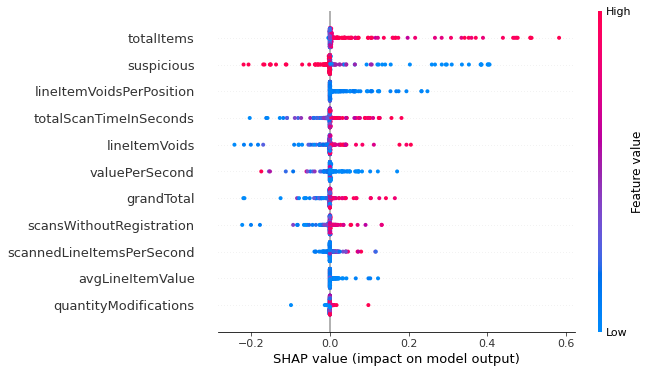

In [11]:
import shap
shap.initjs

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rs, stratify=y) 
final_pipe.fit(X_train, y_train)
X_train = shap.kmeans(X_train, 20)
explainer = shap.KernelExplainer(final_pipe.predict, X_train)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

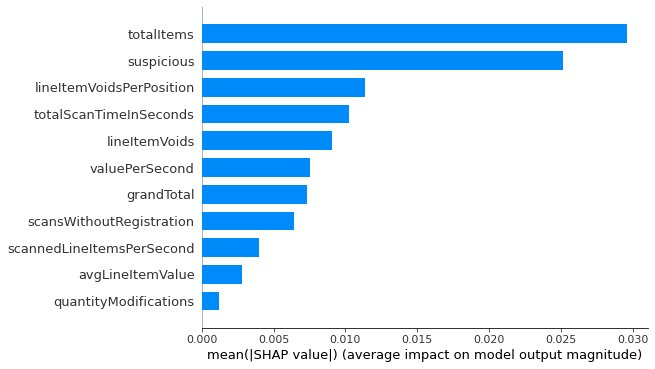

In [12]:
# simple feature importance
shap.summary_plot(shap_values, features=X_test, feature_names=X.columns, plot_type="bar")